# Introduction
## Overview
The notebook applies the [SimGAN](https://arxiv.org/pdf/1612.07828v1.pdf) network architecture to the problem of generating realistic images of eyes by using real images to augment the simulated data. We use Keras with a Tensorflow-backend to accomplish the adversarial training. 
### Note 
The model is quite small and the training is tuned down substantially since the limits of Kaggle Kernels and the lack of GPU makes the training very slow

In [1]:
import os
import sys
import keras
from keras import applications
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
import h5py
import numpy as np
import tensorflow as tf
import cv2
from matplotlib import cm

Using TensorFlow backend.
C:\Users\localadmin\Anaconda3\envs\simgan\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\localadmin\Anaconda3\envs\simgan\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\localadmin\Anaconda3\envs\simgan\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\localadmin\Anaconda3

In [2]:
print('tf-version',tf.__version__, 'keras-version', keras.__version__)

tf-version 1.13.1 keras-version 2.0.3


## Loading Data
Here we setup the paths and load the data from the hdf5 files since there would otherwise be too many individual jpg/png images

In [3]:
path = os.path.dirname(os.path.abspath('.'))
data_dir = os.path.join('..', 'input')
cache_dir = '.'

# load the data file and extract dimensions
# with h5py.File(os.path.join(data_dir,'gaze.h5'),'r') as t_file:
#     print(list(t_file.keys()))
#     assert 'image' in t_file, "Images are missing"
#     assert 'look_vec' in t_file, "Look vector is missing"
#     assert 'path' in t_file, "Paths are missing"
#     print('Synthetic images found:',len(t_file['image']))
    
#     for _, (ikey, ival) in zip(range(1), t_file['image'].items()):
#         print('image',ikey,'shape:',ival.shape)
#         img_height, img_width = ival.shape
#         img_channels = 1
#     syn_image_stack = np.stack([np.expand_dims(a,-1) for a in t_file['image'].values()],0)
#     print(syn_image_stack.shape)


######## my syn ##########
with h5py.File('syn.h5','r') as t_file:
    assert 'image' in t_file, "Images are missing"
    print('Synthetic images found:',len(t_file['image']))
    for _, (ikey, ival) in zip(range(1), t_file.items()):
        img_height = ival.shape[1]
        img_width = ival.shape[2]
        img_channels = 1
    tmp = np.stack([np.expand_dims(a,-1) for a in t_file.values()],0)
    syn_image_stack = tmp[0]
    print(syn_image_stack.shape)

# with h5py.File(os.path.join(data_dir,'real_gaze.h5'),'r') as t_file:
#     print(list(t_file.keys()))
#     assert 'image' in t_file, "Images are missing"
#     print('Real Images found:',len(t_file['image']))
#     for _, (ikey, ival) in zip(range(1), t_file['image'].items()):
#         print('image',ikey,'shape:',ival.shape)
#          img_height, img_width = ival.shape
#         img_channels = 1
#     real_image_stack = np.stack([np.expand_dims(a,-1) for a in t_file['image'].values()],0)

######## my real #########
with h5py.File('real.h5','r') as t_file:
    assert 'image' in t_file, "Images are missing"
    print('Real Images found:',len(t_file['image']))
    for _, (ikey, ival) in zip(range(1), t_file.items()):
        img_height = ival.shape[1]
        img_width = ival.shape[2]
        img_channels = 1
    tmp1 = np.stack([np.expand_dims(a,-1) for a in t_file.values()],0)
    real_image_stack = tmp1[0]
    print(real_image_stack.shape)

Synthetic images found: 50
(50, 240, 320, 1)
Real Images found: 40
(40, 240, 320, 1)


In [4]:
#
# training params
#

nb_steps = 2000 # originally 10000, but this makes the kernel time out
batch_size = 5
k_d = 1  # number of discriminator updates per step
k_g = 2  # number of generative network updates per step
log_interval = 20
save_interval = 50
pre_steps = 15 # for pretraining

## Utility Functions
These functions make it a bit easier to keep track of how the training is going and make it 

In [5]:

"""
Module to plot a batch of images along w/ their corresponding label(s)/annotations and save the plot to disc.

Use cases:
Plot images along w/ their corresponding ground-truth label & model predicted label,
Plot images generated by a GAN along w/ any annotations used to generate these images,
Plot synthetic, generated, refined, and real images and see how they compare as training progresses in a GAN,
etc...
"""
import matplotlib
from matplotlib import pyplot as plt

from itertools import groupby
# from skimage.util.montage import montage2d
from skimage.util import montage
def plot_batch(image_batch, figure_path, label_batch=None):
    
    all_groups = {label: montage(np.stack([img[:,:,0] for img, lab in img_lab_list],0)) 
                  for label, img_lab_list in groupby(zip(image_batch, label_batch), lambda x: x[1])}
    fig, c_axs = plt.subplots(1,len(all_groups), figsize=(len(all_groups)*4, 8), dpi = 600)
    for c_ax, (c_label, c_mtg) in zip(c_axs, all_groups.items()):
        c_ax.imshow(c_mtg, cmap='bone')
        c_ax.set_title(c_label)
        c_ax.axis('off')
    fig.savefig(os.path.join(figure_path))
    plt.close()
"""
Module implementing the image history buffer described in `2.3. Updating Discriminator using a History of
Refined Images` of https://arxiv.org/pdf/1612.07828v1.pdf.

"""
class ImageHistoryBuffer(object):
    def __init__(self, shape, max_size, batch_size):
        """
        Initialize the class's state.

        :param shape: Shape of the data to be stored in the image history buffer
                      (i.e. (0, img_height, img_width, img_channels)).
        :param max_size: Maximum number of images that can be stored in the image history buffer.
        :param batch_size: Batch size used to train GAN.
        """
        self.image_history_buffer = np.zeros(shape=shape)
        self.max_size = max_size
        self.batch_size = batch_size

    def add_to_image_history_buffer(self, images, nb_to_add=None):
        """
        To be called during training of GAN. By default add batch_size // 2 images to the image history buffer each
        time the generator generates a new batch of images.

        :param images: Array of images (usually a batch) to be added to the image history buffer.
        :param nb_to_add: The number of images from `images` to add to the image history buffer
                          (batch_size / 2 by default).
        """
        if not nb_to_add:
            nb_to_add = self.batch_size // 2

        if len(self.image_history_buffer) < self.max_size:
            np.append(self.image_history_buffer, images[:nb_to_add], axis=0)
        elif len(self.image_history_buffer) == self.max_size:
            self.image_history_buffer[:nb_to_add] = images[:nb_to_add]
        else:
            assert False

        np.random.shuffle(self.image_history_buffer)

    def get_from_image_history_buffer(self, nb_to_get=None):
        """
        Get a random sample of images from the history buffer.

        :param nb_to_get: Number of images to get from the image history buffer (batch_size / 2 by default).
        :return: A random sample of `nb_to_get` images from the image history buffer, or an empty np array if the image
                 history buffer is empty.
        """
        if not nb_to_get:
            nb_to_get = self.batch_size // 2

        try:
            return self.image_history_buffer[:nb_to_get]
        except IndexError:
            return np.zeros(shape=0)

# Network Architectures
Here we define the two primary networks

 - refiner network
 - discriminator network

They work against each other to constantly improve the results of the other one.

In [6]:
def refiner_network(input_image_tensor):
    """
    The refiner network, Rθ, is a residual network (ResNet). It modifies the synthetic image on a pixel level, rather
    than holistically modifying the image content, preserving the global structure and annotations.

    :param input_image_tensor: Input tensor that corresponds to a synthetic image.
    :return: Output tensor that corresponds to a refined synthetic image.
    """
    def resnet_block(input_features, nb_features=64, nb_kernel_rows=3, nb_kernel_cols=3):
        """
        A ResNet block with two `nb_kernel_rows` x `nb_kernel_cols` convolutional layers,
        each with `nb_features` feature maps.

        See Figure 6 in https://arxiv.org/pdf/1612.07828v1.pdf.

        :param input_features: Input tensor to ResNet block.
        :return: Output tensor from ResNet block.
        """
        y = layers.Convolution2D(nb_features, nb_kernel_rows, nb_kernel_cols, border_mode='same')(input_features)
        y = layers.Activation('relu')(y)
        y = layers.Convolution2D(nb_features, nb_kernel_rows, nb_kernel_cols, border_mode='same')(y)

        y = layers.merge([input_features, y], mode='sum')
        return layers.Activation('relu')(y)

    # an input image of size w × h is convolved with 3 × 3 filters that output 64 feature maps
    x = layers.Convolution2D(64, 3, 3, border_mode='same', activation='relu')(input_image_tensor)

    # the output is passed through 4 ResNet blocks
    for _ in range(4):
        x = resnet_block(x)

    # the output of the last ResNet block is passed to a 1 × 1 convolutional layer producing 1 feature map
    # corresponding to the refined synthetic image
    return layers.Convolution2D(img_channels, 1, 1, border_mode='same', activation='tanh')(x)

In [7]:
def discriminator_network(input_image_tensor):
    """
    The discriminator network, Dφ, contains 5 convolution layers and 2 max-pooling layers.

    :param input_image_tensor: Input tensor corresponding to an image, either real or refined.
    :return: Output tensor that corresponds to the probability of whether an image is real or refined.
    """
    x = layers.Convolution2D(96, 3, 3, border_mode='same', subsample=(2, 2), activation='relu')(input_image_tensor)
    x = layers.Convolution2D(64, 3, 3, border_mode='same', subsample=(2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), border_mode='same', strides=(1, 1))(x)
    x = layers.Convolution2D(32, 3, 3, border_mode='same', subsample=(1, 1), activation='relu')(x)
    x = layers.Convolution2D(32, 1, 1, border_mode='same', subsample=(1, 1), activation='relu')(x)
    x = layers.Convolution2D(2, 1, 1, border_mode='same', subsample=(1, 1), activation='relu')(x)

    # here one feature map corresponds to `is_real` and the other to `is_refined`,
    # and the custom loss function is then `tf.nn.sparse_softmax_cross_entropy_with_logits`
    return layers.Reshape((-1, 2))(x)

## Combining Models
Adversarial training of refiner network Rθ and discriminator network Dφ and combining them into single loss-functions and models that can be trained


In [8]:
#
# define model input and output tensors
#

synthetic_image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
refined_image_tensor = refiner_network(synthetic_image_tensor)

refined_or_real_image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
discriminator_output = discriminator_network(refined_or_real_image_tensor)

#
# define models
#

refiner_model = models.Model(input=synthetic_image_tensor, output=refined_image_tensor, name='refiner')
discriminator_model = models.Model(input=refined_or_real_image_tensor, output=discriminator_output,
                                   name='discriminator')

# combined must output the refined image along w/ the disc's classification of it for the refiner's self-reg loss
refiner_model_output = refiner_model(synthetic_image_tensor)
combined_output = discriminator_model(refiner_model_output)
combined_model = models.Model(input=synthetic_image_tensor, output=[refiner_model_output, combined_output],
                              name='combined')

discriminator_model_output_shape = discriminator_model.output_shape

print(refiner_model.summary())
print(discriminator_model.summary())
print(combined_model.summary())

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\localadmin\Anaconda3\envs\simgan\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
C:\Users\localadmin\Anaconda3\envs\simgan\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
C:\Users\localadmin\Anaconda3\envs\simgan\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
C:\Users\localadmin\Anaconda3\envs\simgan\lib\site-packages\ipykernel_launcher.py:23: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\localadmin\Anaconda3\envs\simgan\lib\site-packages\keras\legacy\layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers f

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 320, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 240, 320, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 240, 320, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 240, 320, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 240, 320, 64)      36928     
_________________________________________________________________
merge_1 (Merge)              (None, 240, 320, 64)      0         
_________________________________________________________________
activation_2 (Activation)    (None, 240, 320, 64)      0         
__________

C:\Users\localadmin\Anaconda3\envs\simgan\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\localadmin\Anaconda3\envs\simgan\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", strides=(1, 1), padding="same")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\localadmin\Anaconda3\envs\simgan\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu", strides=(1, 1), padding="same")`
  if sys.path[0] == '':
C:\Users\localadmin\Anaconda3\envs\simgan\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(2, (1, 1), activation="relu", strides=(1, 1), padding="same")

## Visualization
Here we show the network architectures visually with shapes (doesn't yet work on kaggle)

In [9]:

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
# Define model
try:
    model_to_dot(refiner_model, show_shapes=True).write_svg('refiner_model.svg')
    SVG('refiner_model.svg')
except ImportError:
    print('Not running the patched version of keras/pydot!')
    pass

Not running the patched version of keras/pydot!


In [10]:
try:
    model_to_dot(discriminator_model, show_shapes=True).write_svg('discriminator_model.svg')
    SVG('discriminator_model.svg')
except ImportError:
    pass

In [11]:
#
# define custom l1 loss function for the refiner
#

def self_regularization_loss(y_true, y_pred):
    delta = 0.0001  # FIXME: need to figure out an appropriate value for this
    return tf.multiply(delta, tf.reduce_sum(tf.abs(y_pred - y_true)))

#
# define custom local adversarial loss (softmax for each image section) for the discriminator
# the adversarial loss function is the sum of the cross-entropy losses over the local patches
#

def local_adversarial_loss(y_true, y_pred):
    # y_true and y_pred have shape (batch_size, # of local patches, 2), but really we just want to average over
    # the local patches and batch size so we can reshape to (batch_size * # of local patches, 2)
    y_true = tf.reshape(y_true, (-1, 2))
    y_pred = tf.reshape(y_pred, (-1, 2))
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)

    return tf.reduce_mean(loss)

# Compile Models
Here we combine the models and compile them with the loss functions defined above

In [12]:
sgd = optimizers.SGD(lr=1e-3)

refiner_model.compile(optimizer=sgd, loss=self_regularization_loss)
discriminator_model.compile(optimizer=sgd, loss=local_adversarial_loss)
discriminator_model.trainable = False
combined_model.compile(optimizer=sgd, loss=[self_regularization_loss, local_adversarial_loss])

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [13]:
refiner_model_path = None
discriminator_model_path = None

# Data Generators
Here we setup the pipeline to feed new images to both models

In [14]:
datagen = image.ImageDataGenerator(
    preprocessing_function=applications.xception.preprocess_input,
    data_format='channels_last')

flow_from_directory_params = {'target_size': (img_height, img_width),
                              'color_mode': 'grayscale' if img_channels == 1 else 'rgb',
                              'class_mode': None,
                              'batch_size': batch_size}
flow_params = {'batch_size': batch_size}

synthetic_generator = datagen.flow(
    x = syn_image_stack,
    **flow_params
)

real_generator = datagen.flow(
    x = real_image_stack,
    **flow_params
)

def get_image_batch(generator):
    """keras generators may generate an incomplete batch for the last batch"""
    img_batch = generator.next()
    if len(img_batch) != batch_size:
        img_batch = generator.next()

    assert len(img_batch) == batch_size

    return img_batch

# the target labels for the cross-entropy loss layer are 0 for every yj (real) and 1 for every xi (refined)
y_real = np.array([[[1.0, 0.0]] * discriminator_model_output_shape[1]] * batch_size)
y_refined = np.array([[[0.0, 1.0]] * discriminator_model_output_shape[1]] * batch_size)
assert y_real.shape == (batch_size, discriminator_model_output_shape[1], 2)
batch_out = get_image_batch(synthetic_generator)
assert batch_out.shape == (batch_size, img_height, img_width, img_channels), "Image Dimensions do not match, {}!={}".format(batch_out.shape, (batch_size, img_height, img_width, img_channels))

# Pretraining
Here we pretraining the models before we start the full-blown training procedure

In [15]:
if not refiner_model_path:
    # we first train the Rθ network with just self-regularization loss for 1,000 steps
    print('pre-training the refiner network...')
    gen_loss = np.zeros(shape=len(refiner_model.metrics_names))

    for i in range(pre_steps):
        synthetic_image_batch = get_image_batch(synthetic_generator)
        gen_loss = np.add(refiner_model.train_on_batch(synthetic_image_batch, synthetic_image_batch), gen_loss)

        # log every `log_interval` steps
        if not i % log_interval:
            figure_name = 'refined_image_batch_pre_train_step_{}.png'.format(i)
            print('Saving batch of refined images during pre-training at step: {}.'.format(i))

            synthetic_image_batch = get_image_batch(synthetic_generator)
            plot_batch(
                np.concatenate((synthetic_image_batch, refiner_model.predict_on_batch(synthetic_image_batch))),
                os.path.join(cache_dir, figure_name),
                label_batch=['Synthetic'] * batch_size + ['Refined'] * batch_size)

            print('Refiner model self regularization loss: {}.'.format(gen_loss / log_interval))
            gen_loss = np.zeros(shape=len(refiner_model.metrics_names))

    refiner_model.save(os.path.join(cache_dir, 'refiner_model_pre_trained.h5'))
else:
    refiner_model.load_weights(refiner_model_path)

if not discriminator_model_path:
    # and Dφ for 200 steps (one mini-batch for refined images, another for real)
    print('pre-training the discriminator network...')
    disc_loss = np.zeros(shape=len(discriminator_model.metrics_names))

    for _ in range(pre_steps):
        real_image_batch = get_image_batch(real_generator)
        disc_loss = np.add(discriminator_model.train_on_batch(real_image_batch, y_real), disc_loss)

        synthetic_image_batch = get_image_batch(synthetic_generator)
        refined_image_batch = refiner_model.predict_on_batch(synthetic_image_batch)
        disc_loss = np.add(discriminator_model.train_on_batch(refined_image_batch, y_refined), disc_loss)

    discriminator_model.save(os.path.join(cache_dir, 'discriminator_model_pre_trained.h5'))

    # hard-coded for now
    print('Discriminator model loss: {}.'.format(disc_loss / (100 * 2)))
else:
    discriminator_model.load_weights(discriminator_model_path)

pre-training the refiner network...
Saving batch of refined images during pre-training at step: 0.
Refiner model self regularization loss: [0.55880656].
pre-training the discriminator network...
Discriminator model loss: [0.10464593].


In [16]:
Refiner_model_loss = []
Discriminator_model_loss_real = []
Discriminator_model_loss_refined = []

# Full Training
Here we run the full training of the model (normally for thousands of iterations, but here just a few). The images are saved in the output directory for examining the training

In [17]:
# TODO: what is an appropriate size for the image history buffer?
image_history_buffer = ImageHistoryBuffer((0, img_height, img_width, img_channels), batch_size * 100, batch_size)

combined_loss = np.zeros(shape=len(combined_model.metrics_names))
disc_loss_real = np.zeros(shape=len(discriminator_model.metrics_names))
disc_loss_refined = np.zeros(shape=len(discriminator_model.metrics_names))

# see Algorithm 1 in https://arxiv.org/pdf/1612.07828v1.pdf
for i in range(nb_steps):
    print('Step: {} of {}.'.format(i, nb_steps))

    # train the refiner
    for _ in range(k_g * 2):
        # sample a mini-batch of synthetic images
        synthetic_image_batch = get_image_batch(synthetic_generator)

        # update θ by taking an SGD step on mini-batch loss LR(θ)
        combined_loss = np.add(combined_model.train_on_batch(synthetic_image_batch,
                                                             [synthetic_image_batch, y_real]), combined_loss)

    for _ in range(k_d):
        # sample a mini-batch of synthetic and real images
        synthetic_image_batch = get_image_batch(synthetic_generator)
        real_image_batch = get_image_batch(real_generator)

        # refine the synthetic images w/ the current refiner
        refined_image_batch = refiner_model.predict_on_batch(synthetic_image_batch)

        # use a history of refined images
        half_batch_from_image_history = image_history_buffer.get_from_image_history_buffer()
        image_history_buffer.add_to_image_history_buffer(refined_image_batch)

        if len(half_batch_from_image_history):
            refined_image_batch[:batch_size // 2] = half_batch_from_image_history

        # update φ by taking an SGD step on mini-batch loss LD(φ)
        disc_loss_real = np.add(discriminator_model.train_on_batch(real_image_batch, y_real), disc_loss_real)
        disc_loss_refined = np.add(discriminator_model.train_on_batch(refined_image_batch, y_refined),
                                   disc_loss_refined)

    if not (i+1) % log_interval:
        # plot batch of refined images w/ current refiner
        figure_name = 'refined_image_batch_step_{}.png'.format(i)
        print('Saving batch of refined images at adversarial step: {}.'.format(i))

        synthetic_image_batch = get_image_batch(synthetic_generator)
        plot_batch(
            np.concatenate((synthetic_image_batch, refiner_model.predict_on_batch(synthetic_image_batch))),
            os.path.join(cache_dir, figure_name),
            label_batch=['Synthetic'] * batch_size + ['Refined'] * batch_size)

        # log loss summary
        print('Refiner model loss: {}.'.format(combined_loss / (log_interval * k_g * 2)))
        Refiner_model_loss.append(combined_loss / (log_interval * k_g * 2))
        print('Discriminator model loss real: {}.'.format(disc_loss_real / (log_interval * k_d * 2)))
        Discriminator_model_loss_real.append(disc_loss_real / (log_interval * k_d * 2))
        print('Discriminator model loss refined: {}.'.format(disc_loss_refined / (log_interval * k_d * 2)))
        Discriminator_model_loss_refined.append(disc_loss_refined / (log_interval * k_d * 2))

        combined_loss = np.zeros(shape=len(combined_model.metrics_names))
        disc_loss_real = np.zeros(shape=len(discriminator_model.metrics_names))
        disc_loss_refined = np.zeros(shape=len(discriminator_model.metrics_names))

    # save model checkpoints
    if not (i+1) % save_interval:
        model_checkpoint_base_name = os.path.join(cache_dir, '{}_model_step_{}.h5')
        refiner_model.save(model_checkpoint_base_name.format('refiner', i))
        discriminator_model.save(model_checkpoint_base_name.format('discriminator', i))

Step: 0 of 2000.
Step: 1 of 2000.
Step: 2 of 2000.
Step: 3 of 2000.
Step: 4 of 2000.
Step: 5 of 2000.
Step: 6 of 2000.
Step: 7 of 2000.
Step: 8 of 2000.
Step: 9 of 2000.
Step: 10 of 2000.
Step: 11 of 2000.
Step: 12 of 2000.
Step: 13 of 2000.
Step: 14 of 2000.
Step: 15 of 2000.
Step: 16 of 2000.
Step: 17 of 2000.
Step: 18 of 2000.
Step: 19 of 2000.
Saving batch of refined images at adversarial step: 19.
Refiner model loss: [3.41901793 2.7146315  0.70438643].
Discriminator model loss real: [0.35457378].
Discriminator model loss refined: [0.34108597].
Step: 20 of 2000.
Step: 21 of 2000.
Step: 22 of 2000.
Step: 23 of 2000.
Step: 24 of 2000.
Step: 25 of 2000.
Step: 26 of 2000.
Step: 27 of 2000.
Step: 28 of 2000.
Step: 29 of 2000.
Step: 30 of 2000.
Step: 31 of 2000.
Step: 32 of 2000.
Step: 33 of 2000.
Step: 34 of 2000.
Step: 35 of 2000.
Step: 36 of 2000.
Step: 37 of 2000.
Step: 38 of 2000.
Step: 39 of 2000.
Saving batch of refined images at adversarial step: 39.
Refiner model loss: [2.876587

In [18]:
def my_get_image_batch(generator, length):
    """keras generators may generate an incomplete batch for the last batch"""
    img_batch = generator.next()
    
    if len(img_batch) != length:
        img_batch = generator.next()

    assert len(img_batch) == length

    return img_batch

In [19]:
my_flow_params = {'batch_size': 50}
my_synthetic_generator = datagen.flow(
    x = syn_image_stack,
    **my_flow_params
    )
my_synthetic_image_batch = my_get_image_batch(my_synthetic_generator, 50)

In [20]:
re = refiner_model.predict_on_batch(my_synthetic_image_batch)
di = discriminator_model.predict_on_batch(my_synthetic_image_batch)

In [30]:
with h5py.File('cal.h5','r') as t_file:
    assert 'image' in t_file, "Images are missing"
    print('Real Images found:',len(t_file['image']))
    for _, (ikey, ival) in zip(range(1), t_file.items()):
        img_height = ival.shape[1]
        img_width = ival.shape[2]
        img_channels = 1
    tmp2 = np.stack([np.expand_dims(a,-1) for a in t_file.values()],0)
    cal_image_stack = tmp2[0]
    print(cal_image_stack.shape)

Real Images found: 10
(10, 240, 320, 1)


In [31]:
my_cal_flow_params = {'batch_size': 10}
my_cal_generator = datagen.flow(
    x = cal_image_stack,
    **my_cal_flow_params
    )
my_cal_image_batch = my_get_image_batch(my_cal_generator, 10)

In [32]:
re = refiner_model.predict_on_batch(my_cal_image_batch)
di = discriminator_model.predict_on_batch(my_cal_image_batch)

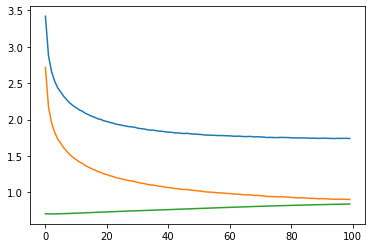

In [27]:
plt.plot(Refiner_model_loss)

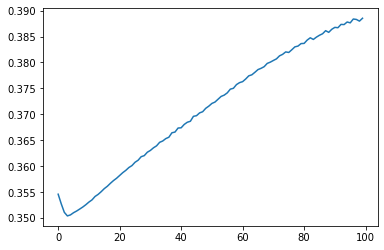

In [28]:
plt.plot(Discriminator_model_loss_real)

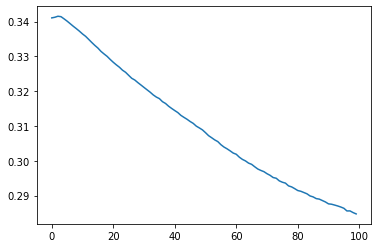

In [29]:
plt.plot(Discriminator_model_loss_refined)

In [ ]:
Refiner_model_loss
Discriminator_model_loss_real
Discriminator_model_loss_refined

In [35]:
import matplotlib.pyplot as plt

for i in range(10):
    number = i
    resized_img = cv2.resize(re[i],(320,240))
    name = str(number) + '.png'
    plt.imsave(name, resized_img, cmap = cm.gray)
    

for i in range(10):
    number = i
    resized_img = cv2.resize(my_cal_image_batch[i],(320,240))
    name = str(number) + '_syn.png'
    plt.imsave(name, resized_img, cmap = cm.gray)

In [ ]:
# serialize model to JSON
model_json = refiner_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
refiner_model.save_weights("model.h5")
print("Saved model into h5 file")

In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model =  keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [ ]:
loaded_model.compile(loss=self_regularization_loss, optimizer=sgd)

In [ ]:
archive = h5py.File('new_test.h5','r')

tmp = np.stack([np.expand_dims(a,-1) for a in archive.values()],0)
my_syn_image_stack = tmp[0]
# syn_image_stack = np.array([np.expand_dims(a,-1) for a in archive.values()])
print(my_syn_image_stack.shape)

archive.close()

In [ ]:
my_synthetic_generator = datagen.flow(
    x = my_syn_image_stack,
    **flow_params
)

my_synthetic_image_batch = get_image_batch(my_synthetic_generator)

In [ ]:
filelot
ath = 'C:\\Users\\localadmin\\Documents\\Yifan\\UnityEyes_Windows\\imgs\\'

array = []
for i in range(1,50):
    filename = filepath+str(i)+'.jpg'
    img = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
    r_img = image_resize(img, width = 55, height = 35)
    resized_image = cv2.resize(r_img, (55, 35)) 
    array.append(resized_image)

archive = h5py.File('new_test.h5', 'w')
archive['image'] = array

archive.close()